In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from netCDF4 import Dataset
import cartopy.crs as ccrs
import xarray as xr
import pysal as ps
import libpysal
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import OPTICS
from sklearn.cluster import KMeans

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/pysal/explore/segregation/network/network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
def optics_labels(idxs,obu,obv,min_obs=8,max_dist=7.):
    # define features for clustering:
    # 1. u-component
    # 2. v-component
    # predictors are stored in a matrix of {n_samples, n_features}
    n_feat = 2
    X = np.nan * np.ones((np.size(idxs),n_feat))
    feat1 = obu[idxs]
    feat2 = obv[idxs]
    X[:,0] = feat1
    X[:,1] = feat2
    # define settings for affinity propagation and generate clustering
    # see for details:
    # https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html#sklearn.cluster.AffinityPropagation
    dampCoef  = 0.70  # can be increased up to 0.95, if not converging - lower value may or may not produce more indiv. clusters
    iterMax   = 500   # set higher than iterCnv
    iterCnv   = 50   # can be increased if not converging (try increasing dampCoef first, though)
    cop       = True
    pref      = None
    affTyp    = 'euclidean'
    outVerb   = False
    randState = 90210  # sets random number seed, for reproducibility
    clustering = OPTICS(
                        min_samples=min_obs,          # how many obs necessary to create a cluster
                        max_eps=np.sqrt(2*max_dist),  # how close in X-space obs need to be to be clustered
                        n_jobs=1
                       ).fit(X)
    # compute empirical centers for all clusters with labels != -1
    cluLabels = np.unique(clustering.labels_)
    mask = np.ones(len(cluLabels), dtype=bool)
    mask[np.where(cluLabels==-1)] = False
    cluLabels = cluLabels[mask]  # removing the clustering.lanels_==-1 non-cluster
    nClusters = np.size(cluLabels)
    clusterCenters = np.nan * np.ones((nClusters,2))
    for i in range(np.size(cluLabels)):
        clu = cluLabels[i]
        mems = np.where(clustering.labels_ == clu)[0]
        clusterCenters[i,0] = np.mean(feat1[mems])
        clusterCenters[i,1] = np.mean(feat2[mems])
        
    return clustering.labels_, clusterCenters

def haversine_np(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [3]:
data_dir='test-data/ops.v16.3.2023040300'
diag_file=data_dir+'/diag_conv_uv_ges.2023040300.nc4'
diag_hdl=Dataset(diag_file)
ob_use=np.asarray(diag_hdl.variables['Analysis_Use_Flag']).squeeze()
ob_typ=np.asarray(diag_hdl.variables['Observation_Type']).squeeze()
ob_sty=np.asarray(diag_hdl.variables['Observation_Subtype']).squeeze()
ob_pre=np.asarray(diag_hdl.variables['Pressure']).squeeze()
ob_lat=np.asarray(diag_hdl.variables['Latitude']).squeeze()
ob_lon=np.asarray(diag_hdl.variables['Longitude']).squeeze()
ob_tim=np.asarray(diag_hdl.variables['Time']).squeeze()
ob_uwd=np.asarray(diag_hdl.variables['u_Observation']).squeeze()
ob_vwd=np.asarray(diag_hdl.variables['v_Observation']).squeeze()
fix=np.where(ob_lon>180.)
ob_lon[fix]=ob_lon[fix]-360.

In [4]:
# Pre-screening for pressure and time into discrete groups, then use DistanceBand grouping
# and pressure/time NearestNeighbors against all obs to reach out and include obs outside
# of initial screening. Use this expanded group to test for similarity via clustering with
# affinity propagation
#
# Perform similarity-based clustering on DistanceBand connected-groups, which can include
# multiple proximity-based clusters but will contain no observations with proximity-neighbors
# outside of the connected-group.
#
# define index of all qualifiable observations (meeting use and typ requirements)
allidx=np.where((ob_use==1.)&(ob_typ>=240)&(ob_typ<=260))[0]
# define index of all searching observations (meeting pressure and time requirements in subset)
thresPres = 50. # +/- range of pressure bin
thresTime = 1.0  # +/- range of time bin
srcPres = 450.  # center of pressure bin
srcTime = -2.5  # center of time bin
minPres = srcPres - thresPres
maxPres = srcPres + thresPres
minTime = srcTime - thresTime
maxTime = srcTime + thresTime
srcidx=np.intersect1d(allidx,np.where((ob_pre <= maxPres)&(ob_pre >= minPres) &
                                      (ob_tim <= maxTime)&(ob_tim >= minTime))[0])
# define index of all expanding observations (qualifiable and within threshPres and threshTime of pressure/time req.)
minPresExp = minPres - thresPres
maxPresExp = maxPres + thresPres
minTimeExp = minTime - thresTime
maxTimeExp = maxTime + thresTime
expidx=np.intersect1d(allidx,np.where((ob_pre <= maxPresExp)&(ob_pre >= minPresExp) &
                                      (ob_tim <= maxTimeExp)&(ob_tim >= minTimeExp))[0])
print('{:d} observations in total'.format(np.size(allidx)))
print('{:d} observations in search'.format(np.size(srcidx)))
print('{:d} observations in expanded range'.format(np.size(expidx)))

582778 observations in total
20266 observations in search
62364 observations in expanded range


In [5]:
# Construct a geopandas point dataset that contains all relevant ob-info
point_list=[]
nob_list=[]
for i in expidx:
    point_list.append(Point(ob_lon[i],ob_lat[i]))
d = {'geometry': point_list, 
     'lat': list(ob_lat[expidx]),
     'lon': list(ob_lon[expidx]),
     'pre': list(ob_pre[expidx]),
     'tim': list(ob_tim[expidx]),
     'uob': list(ob_uwd[expidx]),
     'vob': list(ob_vwd[expidx]),
     'ob_idx': list(expidx),
     'clusterIndex': -1  # placeholder, -1 == no assigned cluster
    }
gdf = gpd.GeoDataFrame(d, crs="EPSG:4326")
# Transform gdf into cylindrical equidistant projection, where Point() units are in m
gdfE = gdf.to_crs("EPSG:4087")
gdfE

,geometry,lat,lon,pre,tim,uob,vob,ob_idx,clusterIndex
0,POINT (111319.491 -9034690.280),-81.160004,1.000000,425.000000,-2.550000,-3.314330,13.293052,0,-1
1,POINT (939536.456 -9013539.305),-80.970001,8.440000,450.000000,-2.550000,-13.800393,8.292113,1,-1
2,POINT (921725.354 -9082556.846),-81.589996,8.280000,437.000000,-2.550000,-11.190902,9.062214,2,-1
3,POINT (551031.458 -9124858.796),-81.970001,4.950000,412.000000,-2.550000,-8.955636,14.332013,3,-1
4,POINT (732482.241 -9122631.931),-81.949997,6.580000,412.000000,-2.550000,-10.281547,13.159780,4,-1
...,...,...,...,...,...,...,...,...,...
62359,POINT (-115960.068 8143677.431),73.155899,-1.041687,512.000000,-1.050000,8.776244,8.183980,1850189,-1
62360,POINT (-682287.106 9376833.460),84.233528,-6.129089,419.700012,-0.900000,12.279324,-1.725746,1850208,-1
62361,POINT (-646052.557 9362170.290),84.101807,-5.803589,420.200012,-0.900000,12.247335,-1.939787,1850210,-1
62362,POINT (-602663.503 9360460.648),84.086449,-5.413818,420.200012,-0.900000,11.975852,-2.327870,1850211,-1


In [6]:
# Define weights by a DistanceBand cutoff distance around each ob
distThreshold=1000.*100. # m
w=libpysal.weights.distance.DistanceBand.from_dataframe(gdfE,threshold=distThreshold) # threshold in m

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3427 disconnected components.
 There are 1726 islands with ids: 24, 25, 28, 39, 40, 45, 294, 1392, 1393, 1394, 1395, 1412, 1437, 1439, 1450, 1459, 1463, 1464, 1473, 1479, 1486, 1487, 1551, 1705, 2832, 3042, 3043, 3045, 3052, 3053, 3054, 3066, 3077, 3086, 3096, 3097, 3119, 3125, 3143, 3144, 3145, 3146, 3147, 3155, 3221, 3229, 3235, 3256, 3258, 3261, 3275, 3289, 3298, 3345, 3346, 3358, 3371, 3434, 4213, 4227, 4273, 4297, 4319, 4333, 4344, 4345, 4355, 4358, 4359, 4360, 4361, 4363, 4364, 4365, 4366, 4368, 4371, 4372, 4380, 4383, 4385, 4387, 4391, 4392, 4393, 4397, 4398, 4402, 4415, 4427, 4438, 4439, 4440, 4443, 4459, 4488, 4490, 4491, 4492, 4493, 4494, 4497, 4502, 4644, 4646, 4648, 4651, 4669, 4694, 5304, 5312, 5337, 5346, 5589, 5599, 5600, 5608, 5634, 5641, 5645, 5651, 5661, 5668, 5676, 5679, 5685, 5694, 5698

In [7]:
# trim islands from gdfE, as these are 1-member clusters by definition, recompute w
gdfE_islands=gdfE.iloc[w.islands]
gdfE_islands=gdfE_islands.reset_index() # Resets index numbering to start at 0
gdfE=gdfE.drop(index=w.islands)
gdfE=gdfE.reset_index() # Resets index numbering to start at 0
w = libpysal.weights.distance.DistanceBand.from_dataframe(gdfE,threshold=distThreshold) # threshold in m

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 1701 disconnected components.
  warnings.warn(message)


In [8]:
# attach component-groups to gdfE
gdfE = gdfE.assign(compGroup=w.component_labels)

In [9]:
# define a cluster index value
clusterID = -1  # first valid cluster will increment, so clusterIndex will begin at 0
# loop over component-groups
for ic in np.unique(gdfE['compGroup'].values):
    # extract all component-neighbors from a component of w
    gdfEsub = gdfE.loc[gdfE['compGroup']==ic]
    compIDX = gdfEsub.index
    print('operating on component group {:d} of {:d}, with {:d} observations'.format(ic,np.size(np.unique(gdfE['compGroup'].values)),np.size(compIDX)))
    # compute pressure and time proximity-neighbor lists among expidx[compIDX]
    neighPres = NearestNeighbors(radius=thresPres)
    neighPres.fit(np.reshape(gdfEsub['pre'].values,(-1,1)))
    neighPresList = neighPres.radius_neighbors(np.reshape(gdfEsub['pre'].values,(-1,1)),return_distance=False)
    neighTime = NearestNeighbors(radius=thresTime)
    neighTime.fit(np.reshape(gdfEsub['tim'].values,(-1,1)))
    neighTimeList = neighTime.radius_neighbors(np.reshape(gdfEsub['tim'].values,(-1,1)),return_distance=False)
    # create gdfE subset for component-group
    gdfEsub = gdfE.loc[gdfE['compGroup']==ic]
    gdfEsub = gdfEsub.reset_index()
    # decide if similarity clusters can be generated: there must be at least as many observations as the
    # minimum number of obs necessary to form a cluster in OPTICS.
    minObs = 8
    maxDist = 7.
    if (len(gdfEsub) <= minObs):
        # no clustering necessary, these can be considered islands
        gdfE_islands = gpd.GeoDataFrame(pd.concat([gdfE_islands,gdfEsub], ignore_index=True, verify_integrity=False, sort=False))
        # reassert column types (integers tend to turn into floats after update)
        convert_dict = {'ob_idx': int,
                        'clusterIndex': int
                        }
        gdfE_islands = gdfE_islands.astype(convert_dict)
        gdfE=gdfE.drop(index=gdfEsub['level_0'].values)
    else:
        # generate OPTICS clusters and return cluster centers
        ob_sim, clusterCenters = optics_labels(gdfEsub['ob_idx'].values,ob_uwd,ob_vwd,min_obs=minObs,max_dist=maxDist)  # similarity-labels, from OPTICS clustering
        # if only a -1 cluster is discovered, clusterCenters.size == 0, and these can be considered islands
        if clusterCenters.size == 0:
            # no clustering necessary, these can be considered islands
            gdfE_islands = gpd.GeoDataFrame(pd.concat([gdfE_islands,gdfEsub], ignore_index=True, verify_integrity=False, sort=False))
            # reassert column types (integers tend to turn into floats after update)
            convert_dict = {'ob_idx': int,
                            'clusterIndex': int
                            }
            gdfE_islands = gdfE_islands.astype(convert_dict)
            gdfE=gdfE.drop(index=gdfEsub['level_0'].values)
        else:
            # use clusterCenters to initialize a k-means search to assign each observation to a cluster
            idxs = gdfEsub['ob_idx'].values
            obu = ob_uwd
            obv = ob_vwd
            n_feat = 2
            X = np.nan * np.ones((np.size(idxs),n_feat))
            feat1 = obu[idxs]
            feat2 = obv[idxs]
            X[:,0] = feat1
            X[:,1] = feat2
            clustering = KMeans(n_clusters=np.shape(clusterCenters)[0],
                                init=clusterCenters,
                                n_init=1).fit(X)
            ob_sim = clustering.labels_
            # assign ob_sim values as similGroup
            gdfEsub = gdfEsub.assign(similGroup=ob_sim)
            # loop through similGroup values
            for si in np.unique(gdfEsub['similGroup'].values):
                gdfEsubcl = gdfEsub.loc[gdfEsub['similGroup']==si]
                # loop through similarity subcluster
                for i in range(len(gdfEsubcl)):
                    # if member i has not been assigned a cluster, compute clustering around member i
                    if gdfEsubcl.iloc[i]['clusterIndex'] == -1:
                        # increment clusterID
                        clusterID = clusterID + 1
                        # Define proximity, pressure, and time neighbors among subcluster members
                        proxlist=np.where(np.isin(gdfEsubcl['level_0'].values,w.neighbors[gdfEsubcl['level_0'].values[i]]))[0]
                        preslist=np.where(np.isin(gdfEsubcl.index,neighPresList[gdfEsubcl.index[i]]))[0]
                        timelist=np.where(np.isin(gdfEsubcl.index,neighTimeList[gdfEsubcl.index[i]]))[0]
                        # Define 4d neighbors to subcluster member i
                        idx4d=np.intersect1d(proxlist,np.intersect1d(preslist,timelist))
                        # Define all members of cluster as member i and any members in idx4d
                        ids = np.append(i,idx4d)
                        # assign any member of ids with a -1 (unassigned) clusterIndex to clusterID
                        gdfEsubcl.iloc[ids, gdfEsubcl.columns.get_loc('clusterIndex')] = np.where(gdfEsubcl.iloc[ids, gdfEsubcl.columns.get_loc('clusterIndex')]==-1,
                                                                                                  clusterID,
                                                                                                  gdfEsubcl.iloc[ids, gdfEsubcl.columns.get_loc('clusterIndex')])
                # assign corresponding members of gdfE a clusterIndex value from gdfEsubcl, following clustering
                gdfE.set_index('index', inplace=True)
                gdfE.update(gdfEsubcl.set_index('index'))
                gdfE=gdfE.reset_index()  # to recover the initial structure
                # reassert column types (integers tend to turn into floats after update)
                convert_dict = {'ob_idx': int,
                                'clusterIndex': int,
                                'compGroup': int
                               }
                gdfE = gdfE.astype(convert_dict)
                gdfE = gdfE.set_crs("EPSG:4087")

operating on component group 0 of 1701, with 3 observations
operating on component group 1 of 1700, with 6006 observations
operating on component group 2 of 1700, with 3 observations
operating on component group 3 of 1699, with 8 observations
operating on component group 4 of 1698, with 4 observations
operating on component group 5 of 1697, with 4 observations
operating on component group 6 of 1696, with 4 observations
operating on component group 7 of 1695, with 2 observations
operating on component group 8 of 1694, with 5 observations
operating on component group 9 of 1693, with 2 observations
operating on component group 10 of 1692, with 5 observations
operating on component group 11 of 1691, with 62 observations
operating on component group 12 of 1691, with 28 observations
operating on component group 13 of 1691, with 3 observations
operating on component group 14 of 1690, with 3 observations
operating on component group 15 of 1689, with 3 observations
operating on component group 

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 35 of 1673, with 14 observations
operating on component group 36 of 1673, with 2 observations
operating on component group 37 of 1672, with 5 observations
operating on component group 38 of 1671, with 7 observations
operating on component group 39 of 1670, with 2 observations
operating on component group 40 of 1669, with 5 observations
operating on component group 41 of 1668, with 2 observations
operating on component group 42 of 1667, with 6 observations
operating on component group 43 of 1666, with 12 observations
operating on component group 44 of 1666, with 2 observations
operating on component group 45 of 1665, with 5 observations
operating on component group 46 of 1664, with 2 observations
operating on component group 47 of 1663, with 6 observations
operating on component group 48 of 1662, with 3 observations
operating on component group 49 of 1661, with 10 observations
operating on component group 50 of 1661, with 2 observations
operating on componen

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 75 of 1645, with 22 observations
operating on component group 76 of 1645, with 4 observations
operating on component group 77 of 1644, with 8 observations
operating on component group 78 of 1643, with 3 observations
operating on component group 79 of 1642, with 5 observations
operating on component group 80 of 1641, with 10 observations
operating on component group 81 of 1640, with 3 observations
operating on component group 82 of 1639, with 517 observations
operating on component group 83 of 1639, with 2 observations
operating on component group 84 of 1638, with 3 observations
operating on component group 85 of 1637, with 6 observations
operating on component group 86 of 1636, with 25 observations
operating on component group 87 of 1636, with 5 observations
operating on component group 88 of 1635, with 2 observations
operating on component group 89 of 1634, with 11 observations
operating on component group 90 of 1634, with 11 observations
operating on comp

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 137 of 1594, with 6 observations
operating on component group 138 of 1593, with 2 observations
operating on component group 139 of 1592, with 8 observations
operating on component group 140 of 1591, with 3 observations
operating on component group 141 of 1590, with 7 observations
operating on component group 142 of 1589, with 6 observations
operating on component group 143 of 1588, with 2 observations
operating on component group 144 of 1587, with 2 observations
operating on component group 145 of 1586, with 3 observations
operating on component group 146 of 1585, with 4 observations
operating on component group 147 of 1584, with 2 observations
operating on component group 148 of 1583, with 4 observations
operating on component group 149 of 1582, with 15 observations
operating on component group 150 of 1582, with 2 observations
operating on component group 151 of 1581, with 5 observations
operating on component group 152 of 1580, with 2 observations
operati

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 180 of 1564, with 12 observations
operating on component group 181 of 1563, with 10 observations
operating on component group 182 of 1562, with 5 observations
operating on component group 183 of 1561, with 3 observations
operating on component group 184 of 1560, with 2 observations
operating on component group 185 of 1559, with 97 observations


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 186 of 1559, with 2 observations
operating on component group 187 of 1558, with 9 observations
operating on component group 188 of 1557, with 12 observations
operating on component group 189 of 1557, with 4 observations
operating on component group 190 of 1556, with 2 observations
operating on component group 191 of 1555, with 5 observations


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 192 of 1554, with 8 observations
operating on component group 193 of 1553, with 9 observations
operating on component group 194 of 1553, with 2 observations
operating on component group 195 of 1552, with 3 observations
operating on component group 196 of 1551, with 2 observations
operating on component group 197 of 1550, with 2 observations
operating on component group 198 of 1549, with 4 observations
operating on component group 199 of 1548, with 4 observations
operating on component group 200 of 1547, with 24 observations
operating on component group 201 of 1547, with 4 observations
operating on component group 202 of 1546, with 3 observations
operating on component group 203 of 1545, with 4 observations
operating on component group 204 of 1544, with 2 observations
operating on component group 205 of 1543, with 3 observations
operating on component group 206 of 1542, with 118 observations
operating on component group 207 of 1542, with 3 observations
opera

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 218 of 1534, with 8 observations
operating on component group 219 of 1533, with 3 observations
operating on component group 220 of 1532, with 16 observations
operating on component group 221 of 1531, with 3 observations
operating on component group 222 of 1530, with 4 observations
operating on component group 223 of 1529, with 35 observations


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 224 of 1529, with 6 observations
operating on component group 225 of 1528, with 3 observations
operating on component group 226 of 1527, with 3 observations
operating on component group 227 of 1526, with 2 observations
operating on component group 228 of 1525, with 4 observations
operating on component group 229 of 1524, with 2 observations
operating on component group 230 of 1523, with 2 observations
operating on component group 231 of 1522, with 2 observations
operating on component group 232 of 1521, with 2 observations
operating on component group 233 of 1520, with 7 observations
operating on component group 234 of 1519, with 3 observations
operating on component group 235 of 1518, with 3 observations
operating on component group 236 of 1517, with 24 observations
operating on component group 237 of 1517, with 3 observations
operating on component group 238 of 1516, with 59 observations
operating on component group 239 of 1516, with 3 observations
operat

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 264 of 1494, with 29 observations
operating on component group 265 of 1494, with 18 observations
operating on component group 266 of 1494, with 23 observations
operating on component group 267 of 1494, with 287 observations
operating on component group 268 of 1494, with 9 observations
operating on component group 269 of 1493, with 3 observations
operating on component group 270 of 1492, with 3 observations
operating on component group 271 of 1491, with 3 observations
operating on component group 272 of 1490, with 2 observations
operating on component group 273 of 1489, with 2 observations
operating on component group 274 of 1488, with 3 observations
operating on component group 275 of 1487, with 4 observations
operating on component group 276 of 1486, with 10 observations
operating on component group 277 of 1485, with 4 observations
operating on component group 278 of 1484, with 4 observations
operating on component group 279 of 1483, with 3 observations
op

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 281 of 1481, with 3 observations
operating on component group 282 of 1480, with 3 observations
operating on component group 283 of 1479, with 10 observations
operating on component group 284 of 1478, with 2 observations
operating on component group 285 of 1477, with 2 observations
operating on component group 286 of 1476, with 5 observations
operating on component group 287 of 1475, with 3 observations
operating on component group 288 of 1474, with 2 observations
operating on component group 289 of 1473, with 20 observations


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 290 of 1473, with 4 observations
operating on component group 291 of 1472, with 5 observations
operating on component group 292 of 1471, with 15 observations
operating on component group 293 of 1471, with 3 observations
operating on component group 294 of 1470, with 3 observations
operating on component group 295 of 1469, with 4 observations
operating on component group 296 of 1468, with 3 observations
operating on component group 297 of 1467, with 2 observations
operating on component group 298 of 1466, with 2 observations
operating on component group 299 of 1465, with 7 observations
operating on component group 300 of 1464, with 3 observations
operating on component group 301 of 1463, with 3 observations
operating on component group 302 of 1462, with 6 observations
operating on component group 303 of 1461, with 5 observations
operating on component group 304 of 1460, with 2 observations
operating on component group 305 of 1459, with 16 observations
operat

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 398 of 1390, with 11 observations
operating on component group 399 of 1390, with 10 observations
operating on component group 400 of 1389, with 2 observations
operating on component group 401 of 1388, with 7 observations
operating on component group 402 of 1387, with 2 observations


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 403 of 1386, with 6 observations
operating on component group 404 of 1385, with 5 observations
operating on component group 405 of 1384, with 3 observations
operating on component group 406 of 1383, with 5 observations
operating on component group 407 of 1382, with 2 observations
operating on component group 408 of 1381, with 3 observations
operating on component group 409 of 1380, with 2 observations
operating on component group 410 of 1379, with 3 observations
operating on component group 411 of 1378, with 2 observations
operating on component group 412 of 1377, with 4 observations
operating on component group 413 of 1376, with 6 observations
operating on component group 414 of 1375, with 8 observations
operating on component group 415 of 1374, with 2 observations
operating on component group 416 of 1373, with 5 observations
operating on component group 417 of 1372, with 2 observations
operating on component group 418 of 1371, with 4 observations
operatin

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 451 of 1345, with 2 observations
operating on component group 452 of 1344, with 20 observations
operating on component group 453 of 1344, with 5 observations
operating on component group 454 of 1343, with 2 observations
operating on component group 455 of 1342, with 2 observations
operating on component group 456 of 1341, with 3 observations
operating on component group 457 of 1340, with 2 observations
operating on component group 458 of 1339, with 11 observations
operating on component group 459 of 1338, with 2 observations
operating on component group 460 of 1337, with 4 observations
operating on component group 461 of 1336, with 3 observations
operating on component group 462 of 1335, with 2 observations
operating on component group 463 of 1334, with 2 observations
operating on component group 464 of 1333, with 4 observations
operating on component group 465 of 1332, with 2 observations
operating on component group 466 of 1331, with 4 observations
operat

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 469 of 1328, with 21 observations
operating on component group 470 of 1328, with 2 observations
operating on component group 471 of 1327, with 3 observations
operating on component group 472 of 1326, with 4 observations
operating on component group 473 of 1325, with 2 observations
operating on component group 474 of 1324, with 14 observations
operating on component group 475 of 1324, with 3 observations
operating on component group 476 of 1323, with 58 observations
operating on component group 477 of 1323, with 10 observations
operating on component group 478 of 1322, with 2 observations
operating on component group 479 of 1321, with 3 observations
operating on component group 480 of 1320, with 2 observations
operating on component group 481 of 1319, with 4 observations
operating on component group 482 of 1318, with 18 observations
operating on component group 483 of 1317, with 9 observations
operating on component group 484 of 1316, with 2 observations
ope

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 489 of 1311, with 3 observations
operating on component group 490 of 1310, with 3 observations
operating on component group 491 of 1309, with 2 observations
operating on component group 492 of 1308, with 2 observations
operating on component group 493 of 1307, with 3 observations
operating on component group 494 of 1306, with 3 observations
operating on component group 495 of 1305, with 3 observations
operating on component group 496 of 1304, with 3 observations
operating on component group 497 of 1303, with 2 observations
operating on component group 498 of 1302, with 2 observations
operating on component group 499 of 1301, with 8 observations
operating on component group 500 of 1300, with 139 observations
operating on component group 501 of 1300, with 2 observations
operating on component group 502 of 1299, with 3 observations
operating on component group 503 of 1298, with 2 observations
operating on component group 504 of 1297, with 6 observations
operat

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 585 of 1220, with 2 observations
operating on component group 586 of 1219, with 2 observations
operating on component group 587 of 1218, with 4 observations
operating on component group 588 of 1217, with 3 observations
operating on component group 589 of 1216, with 2 observations
operating on component group 590 of 1215, with 8 observations
operating on component group 591 of 1214, with 3 observations
operating on component group 592 of 1213, with 6 observations
operating on component group 593 of 1212, with 2 observations
operating on component group 594 of 1211, with 9 observations
operating on component group 595 of 1210, with 2 observations
operating on component group 596 of 1209, with 90 observations


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 597 of 1209, with 4 observations
operating on component group 598 of 1208, with 2 observations
operating on component group 599 of 1207, with 2 observations
operating on component group 600 of 1206, with 1540 observations
operating on component group 601 of 1206, with 3 observations
operating on component group 602 of 1205, with 3 observations
operating on component group 603 of 1204, with 3 observations
operating on component group 604 of 1203, with 3 observations
operating on component group 605 of 1202, with 4 observations
operating on component group 606 of 1201, with 2 observations
operating on component group 607 of 1200, with 2 observations
operating on component group 608 of 1199, with 3 observations
operating on component group 609 of 1198, with 2 observations
operating on component group 610 of 1197, with 2 observations
operating on component group 611 of 1196, with 234 observations
operating on component group 612 of 1196, with 10 observations
op

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 620 of 1189, with 5 observations
operating on component group 621 of 1188, with 18 observations
operating on component group 622 of 1188, with 3 observations
operating on component group 623 of 1187, with 16 observations
operating on component group 624 of 1187, with 2 observations
operating on component group 625 of 1186, with 4 observations
operating on component group 626 of 1185, with 8 observations
operating on component group 627 of 1184, with 10 observations
operating on component group 628 of 1183, with 3 observations
operating on component group 629 of 1182, with 2 observations
operating on component group 630 of 1181, with 5 observations
operating on component group 631 of 1180, with 2 observations
operating on component group 632 of 1179, with 3 observations
operating on component group 633 of 1178, with 3 observations
operating on component group 634 of 1177, with 3 observations
operating on component group 635 of 1176, with 2 observations
opera

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 701 of 1115, with 4 observations
operating on component group 702 of 1114, with 2 observations
operating on component group 703 of 1113, with 2 observations
operating on component group 704 of 1112, with 17 observations
operating on component group 705 of 1112, with 8 observations
operating on component group 706 of 1111, with 7 observations
operating on component group 707 of 1110, with 2 observations
operating on component group 708 of 1109, with 5 observations
operating on component group 709 of 1108, with 4 observations
operating on component group 710 of 1107, with 2 observations
operating on component group 711 of 1106, with 4 observations
operating on component group 712 of 1105, with 2 observations
operating on component group 713 of 1104, with 2 observations
operating on component group 714 of 1103, with 2 observations
operating on component group 715 of 1102, with 2 observations
operating on component group 716 of 1101, with 3 observations
operati

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 727 of 1091, with 2 observations
operating on component group 728 of 1090, with 2 observations
operating on component group 729 of 1089, with 2 observations
operating on component group 730 of 1088, with 765 observations
operating on component group 731 of 1088, with 2 observations
operating on component group 732 of 1087, with 9 observations
operating on component group 733 of 1086, with 4 observations
operating on component group 734 of 1085, with 19 observations
operating on component group 735 of 1085, with 2 observations
operating on component group 736 of 1084, with 5 observations
operating on component group 737 of 1083, with 5 observations
operating on component group 738 of 1082, with 5 observations
operating on component group 739 of 1081, with 4 observations
operating on component group 740 of 1080, with 3 observations
operating on component group 741 of 1079, with 3 observations
operating on component group 742 of 1078, with 2 observations
opera

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 780 of 1048, with 5 observations
operating on component group 781 of 1047, with 3 observations
operating on component group 782 of 1046, with 3 observations
operating on component group 783 of 1045, with 3 observations
operating on component group 784 of 1044, with 1373 observations
operating on component group 785 of 1044, with 791 observations
operating on component group 786 of 1044, with 18 observations
operating on component group 787 of 1044, with 583 observations
operating on component group 788 of 1044, with 5 observations
operating on component group 789 of 1043, with 4 observations
operating on component group 790 of 1042, with 2 observations
operating on component group 791 of 1041, with 14 observations
operating on component group 792 of 1041, with 3 observations
operating on component group 793 of 1040, with 2 observations
operating on component group 794 of 1039, with 17 observations
operating on component group 795 of 1039, with 20 observatio

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 833 of 1016, with 2 observations
operating on component group 834 of 1015, with 3 observations
operating on component group 835 of 1014, with 5 observations
operating on component group 836 of 1013, with 2 observations
operating on component group 837 of 1012, with 14 observations
operating on component group 838 of 1012, with 7 observations
operating on component group 839 of 1011, with 2 observations
operating on component group 840 of 1010, with 2 observations
operating on component group 841 of 1009, with 9 observations
operating on component group 842 of 1008, with 2 observations
operating on component group 843 of 1007, with 2 observations
operating on component group 844 of 1006, with 5 observations
operating on component group 845 of 1005, with 10 observations


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 846 of 1005, with 4 observations
operating on component group 847 of 1004, with 2 observations
operating on component group 848 of 1003, with 2 observations
operating on component group 849 of 1002, with 2 observations
operating on component group 850 of 1001, with 5 observations
operating on component group 851 of 1000, with 25 observations
operating on component group 852 of 1000, with 3 observations
operating on component group 853 of 999, with 8 observations
operating on component group 854 of 998, with 2 observations
operating on component group 855 of 997, with 6 observations
operating on component group 856 of 996, with 2 observations
operating on component group 857 of 995, with 5 observations
operating on component group 858 of 994, with 2 observations
operating on component group 859 of 993, with 40 observations
operating on component group 860 of 993, with 2 observations
operating on component group 861 of 992, with 3 observations
operating on co

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 918 of 944, with 9 observations
operating on component group 919 of 943, with 607 observations


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 920 of 943, with 34 observations
operating on component group 921 of 943, with 9 observations
operating on component group 922 of 942, with 2 observations
operating on component group 923 of 941, with 4 observations
operating on component group 924 of 940, with 48 observations


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 925 of 940, with 24 observations
operating on component group 926 of 940, with 13 observations
operating on component group 927 of 940, with 79 observations
operating on component group 928 of 940, with 10 observations
operating on component group 929 of 939, with 8 observations
operating on component group 930 of 938, with 9 observations
operating on component group 931 of 937, with 2 observations
operating on component group 932 of 936, with 8 observations
operating on component group 933 of 935, with 3 observations
operating on component group 934 of 934, with 18 observations


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 935 of 934, with 9 observations
operating on component group 936 of 934, with 3 observations
operating on component group 937 of 933, with 3 observations
operating on component group 938 of 932, with 29 observations
operating on component group 939 of 932, with 3 observations
operating on component group 940 of 931, with 2 observations
operating on component group 941 of 930, with 2 observations
operating on component group 942 of 929, with 12 observations
operating on component group 943 of 928, with 4 observations
operating on component group 944 of 927, with 2 observations
operating on component group 945 of 926, with 2 observations
operating on component group 946 of 925, with 4 observations
operating on component group 947 of 924, with 2 observations
operating on component group 948 of 923, with 2 observations


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 949 of 922, with 2 observations
operating on component group 950 of 921, with 6 observations
operating on component group 951 of 920, with 2 observations
operating on component group 952 of 919, with 2 observations
operating on component group 953 of 918, with 5 observations
operating on component group 954 of 917, with 3 observations
operating on component group 955 of 916, with 6 observations
operating on component group 956 of 915, with 2 observations
operating on component group 957 of 914, with 8 observations
operating on component group 958 of 913, with 66 observations
operating on component group 959 of 913, with 2 observations
operating on component group 960 of 912, with 7 observations
operating on component group 961 of 911, with 3 observations
operating on component group 962 of 910, with 14 observations
operating on component group 963 of 909, with 2 observations
operating on component group 964 of 908, with 2 observations
operating on component

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 987 of 890, with 2 observations
operating on component group 988 of 889, with 9 observations
operating on component group 989 of 889, with 24 observations
operating on component group 990 of 889, with 21 observations
operating on component group 991 of 889, with 10 observations
operating on component group 992 of 888, with 7 observations
operating on component group 993 of 887, with 26 observations


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 994 of 887, with 5 observations
operating on component group 995 of 886, with 19 observations
operating on component group 996 of 886, with 2 observations
operating on component group 997 of 885, with 8 observations
operating on component group 998 of 884, with 3 observations
operating on component group 999 of 883, with 2 observations
operating on component group 1000 of 882, with 39 observations
operating on component group 1001 of 882, with 6 observations
operating on component group 1002 of 881, with 2 observations
operating on component group 1003 of 880, with 2 observations
operating on component group 1004 of 879, with 3 observations
operating on component group 1005 of 878, with 6 observations
operating on component group 1006 of 877, with 6 observations
operating on component group 1007 of 876, with 2 observations
operating on component group 1008 of 875, with 13 observations
operating on component group 1009 of 875, with 54 observations
operating 

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 1028 of 858, with 2 observations
operating on component group 1029 of 857, with 2 observations
operating on component group 1030 of 856, with 3 observations
operating on component group 1031 of 855, with 2 observations
operating on component group 1032 of 854, with 3 observations
operating on component group 1033 of 853, with 25 observations
operating on component group 1034 of 853, with 7 observations
operating on component group 1035 of 852, with 20 observations
operating on component group 1036 of 852, with 2 observations
operating on component group 1037 of 851, with 3 observations
operating on component group 1038 of 850, with 2 observations
operating on component group 1039 of 849, with 8 observations
operating on component group 1040 of 848, with 2 observations
operating on component group 1041 of 847, with 74 observations
operating on component group 1042 of 847, with 44 observations
operating on component group 1043 of 847, with 9 observations
oper

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 1048 of 843, with 5 observations
operating on component group 1049 of 842, with 4 observations
operating on component group 1050 of 841, with 5 observations
operating on component group 1051 of 840, with 2 observations
operating on component group 1052 of 839, with 3 observations
operating on component group 1053 of 838, with 6 observations
operating on component group 1054 of 837, with 28 observations
operating on component group 1055 of 837, with 2 observations
operating on component group 1056 of 836, with 2 observations
operating on component group 1057 of 835, with 9 observations
operating on component group 1058 of 834, with 3 observations
operating on component group 1059 of 833, with 2 observations
operating on component group 1060 of 832, with 2 observations
operating on component group 1061 of 831, with 4 observations


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 1062 of 830, with 4 observations
operating on component group 1063 of 829, with 4 observations
operating on component group 1064 of 828, with 3 observations
operating on component group 1065 of 827, with 32 observations
operating on component group 1066 of 827, with 2 observations
operating on component group 1067 of 826, with 4 observations
operating on component group 1068 of 825, with 5 observations
operating on component group 1069 of 824, with 2 observations
operating on component group 1070 of 823, with 6 observations
operating on component group 1071 of 822, with 5 observations
operating on component group 1072 of 821, with 6 observations
operating on component group 1073 of 820, with 6 observations
operating on component group 1074 of 819, with 4 observations
operating on component group 1075 of 818, with 112 observations
operating on component group 1076 of 818, with 2 observations
operating on component group 1077 of 817, with 2 observations
opera

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 1179 of 749, with 15 observations
operating on component group 1180 of 749, with 24 observations
operating on component group 1181 of 749, with 3 observations
operating on component group 1182 of 748, with 4 observations
operating on component group 1183 of 747, with 455 observations
operating on component group 1184 of 747, with 5 observations
operating on component group 1185 of 746, with 4 observations
operating on component group 1186 of 745, with 5 observations
operating on component group 1187 of 744, with 2 observations
operating on component group 1188 of 743, with 3 observations
operating on component group 1189 of 742, with 2 observations
operating on component group 1190 of 741, with 2 observations
operating on component group 1191 of 740, with 3 observations
operating on component group 1192 of 739, with 2 observations
operating on component group 1193 of 738, with 404 observations
operating on component group 1194 of 738, with 22 observations
o

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 1213 of 726, with 2 observations
operating on component group 1214 of 725, with 2 observations
operating on component group 1215 of 724, with 2 observations
operating on component group 1216 of 723, with 11 observations
operating on component group 1217 of 722, with 2 observations
operating on component group 1218 of 721, with 8 observations
operating on component group 1219 of 720, with 6 observations
operating on component group 1220 of 719, with 3 observations
operating on component group 1221 of 718, with 22 observations


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 1222 of 718, with 2 observations
operating on component group 1223 of 717, with 15 observations
operating on component group 1224 of 717, with 2 observations
operating on component group 1225 of 716, with 71 observations
operating on component group 1226 of 716, with 10 observations
operating on component group 1227 of 715, with 6 observations
operating on component group 1228 of 714, with 2 observations
operating on component group 1229 of 713, with 4 observations
operating on component group 1230 of 712, with 4 observations
operating on component group 1231 of 711, with 11 observations
operating on component group 1232 of 710, with 2 observations
operating on component group 1233 of 709, with 535 observations


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 1234 of 709, with 2 observations
operating on component group 1235 of 708, with 9 observations
operating on component group 1236 of 707, with 4 observations
operating on component group 1237 of 706, with 2 observations
operating on component group 1238 of 705, with 114 observations


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 1239 of 705, with 4 observations
operating on component group 1240 of 704, with 2 observations
operating on component group 1241 of 703, with 4 observations
operating on component group 1242 of 702, with 3 observations
operating on component group 1243 of 701, with 2 observations
operating on component group 1244 of 700, with 6 observations
operating on component group 1245 of 699, with 4 observations
operating on component group 1246 of 698, with 3 observations
operating on component group 1247 of 697, with 31 observations
operating on component group 1248 of 697, with 5 observations
operating on component group 1249 of 696, with 3 observations
operating on component group 1250 of 695, with 3 observations
operating on component group 1251 of 694, with 2 observations
operating on component group 1252 of 693, with 119 observations
operating on component group 1253 of 693, with 2 observations
operating on component group 1254 of 692, with 2 observations
opera

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 1340 of 618, with 4 observations
operating on component group 1341 of 617, with 2 observations
operating on component group 1342 of 616, with 5 observations
operating on component group 1343 of 615, with 7 observations
operating on component group 1344 of 614, with 3 observations
operating on component group 1345 of 613, with 109 observations
operating on component group 1346 of 613, with 2 observations
operating on component group 1347 of 612, with 4 observations
operating on component group 1348 of 611, with 4 observations
operating on component group 1349 of 610, with 2 observations
operating on component group 1350 of 609, with 2 observations
operating on component group 1351 of 608, with 4 observations
operating on component group 1352 of 607, with 180 observations
operating on component group 1353 of 607, with 67 observations
operating on component group 1354 of 607, with 4 observations
operating on component group 1355 of 606, with 3 observations
ope

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 1391 of 578, with 27 observations
operating on component group 1392 of 578, with 7 observations
operating on component group 1393 of 577, with 3 observations
operating on component group 1394 of 576, with 3 observations
operating on component group 1395 of 575, with 4 observations
operating on component group 1396 of 574, with 4 observations
operating on component group 1397 of 573, with 2 observations
operating on component group 1398 of 572, with 20 observations
operating on component group 1399 of 572, with 80 observations
operating on component group 1400 of 572, with 4 observations
operating on component group 1401 of 571, with 78 observations
operating on component group 1402 of 571, with 3 observations
operating on component group 1403 of 570, with 4 observations
operating on component group 1404 of 569, with 2 observations
operating on component group 1405 of 568, with 16 observations
operating on component group 1406 of 568, with 2 observations
ope

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 1438 of 546, with 365 observations
operating on component group 1439 of 546, with 6 observations
operating on component group 1440 of 545, with 2 observations
operating on component group 1441 of 544, with 6 observations
operating on component group 1442 of 543, with 33 observations
operating on component group 1443 of 543, with 2 observations
operating on component group 1444 of 542, with 2 observations
operating on component group 1445 of 541, with 2 observations
operating on component group 1446 of 540, with 3 observations
operating on component group 1447 of 539, with 1006 observations
operating on component group 1448 of 539, with 2 observations
operating on component group 1449 of 538, with 3 observations
operating on component group 1450 of 537, with 9 observations
operating on component group 1451 of 536, with 19 observations
operating on component group 1452 of 536, with 85 observations
operating on component group 1453 of 536, with 10 observations

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 1458 of 533, with 35 observations
operating on component group 1459 of 533, with 52 observations
operating on component group 1460 of 533, with 11 observations
operating on component group 1461 of 533, with 2 observations
operating on component group 1462 of 532, with 3 observations
operating on component group 1463 of 531, with 2 observations
operating on component group 1464 of 530, with 2 observations
operating on component group 1465 of 529, with 4 observations
operating on component group 1466 of 528, with 2 observations
operating on component group 1467 of 527, with 70 observations
operating on component group 1468 of 527, with 4 observations
operating on component group 1469 of 526, with 17 observations
operating on component group 1470 of 526, with 2 observations
operating on component group 1471 of 525, with 13 observations
operating on component group 1472 of 525, with 3 observations
operating on component group 1473 of 524, with 9 observations
op

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 1487 of 514, with 7 observations
operating on component group 1488 of 513, with 35 observations
operating on component group 1489 of 513, with 3 observations
operating on component group 1490 of 512, with 6 observations
operating on component group 1491 of 511, with 2 observations
operating on component group 1492 of 510, with 2 observations
operating on component group 1493 of 509, with 10 observations
operating on component group 1494 of 509, with 2 observations
operating on component group 1495 of 508, with 2 observations
operating on component group 1496 of 507, with 4 observations
operating on component group 1497 of 506, with 3 observations
operating on component group 1498 of 505, with 3 observations
operating on component group 1499 of 504, with 2 observations
operating on component group 1500 of 503, with 3 observations
operating on component group 1501 of 502, with 2 observations
operating on component group 1502 of 501, with 2 observations
operat

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 1517 of 488, with 2 observations
operating on component group 1518 of 487, with 2 observations
operating on component group 1519 of 486, with 7 observations
operating on component group 1520 of 485, with 9 observations
operating on component group 1521 of 485, with 8 observations
operating on component group 1522 of 484, with 17 observations
operating on component group 1523 of 484, with 4 observations
operating on component group 1524 of 483, with 3 observations
operating on component group 1525 of 482, with 8 observations
operating on component group 1526 of 481, with 60 observations
operating on component group 1527 of 481, with 4 observations
operating on component group 1528 of 480, with 2 observations
operating on component group 1529 of 479, with 2 observations
operating on component group 1530 of 478, with 13 observations
operating on component group 1531 of 478, with 6 observations
operating on component group 1532 of 477, with 4 observations
opera

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 1534 of 475, with 11 observations
operating on component group 1535 of 474, with 19 observations
operating on component group 1536 of 474, with 34 observations
operating on component group 1537 of 474, with 2 observations
operating on component group 1538 of 473, with 12 observations
operating on component group 1539 of 472, with 2 observations
operating on component group 1540 of 471, with 4 observations
operating on component group 1541 of 470, with 5 observations
operating on component group 1542 of 469, with 3 observations
operating on component group 1543 of 468, with 3 observations
operating on component group 1544 of 467, with 2 observations
operating on component group 1545 of 466, with 2 observations
operating on component group 1546 of 465, with 4 observations
operating on component group 1547 of 464, with 2 observations
operating on component group 1548 of 463, with 2 observations
operating on component group 1549 of 462, with 24 observations


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 1550 of 462, with 2 observations
operating on component group 1551 of 461, with 3 observations
operating on component group 1552 of 460, with 175 observations
operating on component group 1553 of 460, with 2 observations
operating on component group 1554 of 459, with 7 observations
operating on component group 1555 of 458, with 4 observations
operating on component group 1556 of 457, with 3 observations
operating on component group 1557 of 456, with 2 observations
operating on component group 1558 of 455, with 2 observations
operating on component group 1559 of 454, with 3 observations
operating on component group 1560 of 453, with 5 observations
operating on component group 1561 of 452, with 5 observations
operating on component group 1562 of 451, with 2 observations
operating on component group 1563 of 450, with 4 observations
operating on component group 1564 of 449, with 8 observations
operating on component group 1565 of 448, with 13 observations
opera

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 1581 of 434, with 2 observations
operating on component group 1582 of 433, with 2 observations
operating on component group 1583 of 432, with 6 observations
operating on component group 1584 of 431, with 2 observations
operating on component group 1585 of 430, with 3 observations
operating on component group 1586 of 429, with 2 observations
operating on component group 1587 of 428, with 75 observations
operating on component group 1588 of 428, with 3 observations
operating on component group 1589 of 427, with 15 observations
operating on component group 1590 of 427, with 2 observations
operating on component group 1591 of 426, with 2 observations
operating on component group 1592 of 425, with 5 observations
operating on component group 1593 of 424, with 91 observations
operating on component group 1594 of 424, with 2 observations
operating on component group 1595 of 423, with 2 observations
operating on component group 1596 of 422, with 15 observations
oper

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 1665 of 365, with 22 observations
operating on component group 1666 of 364, with 6 observations
operating on component group 1667 of 363, with 3 observations
operating on component group 1668 of 362, with 2 observations
operating on component group 1669 of 361, with 2 observations
operating on component group 1670 of 360, with 3 observations
operating on component group 1671 of 359, with 2 observations
operating on component group 1672 of 358, with 3 observations
operating on component group 1673 of 357, with 11 observations
operating on component group 1674 of 357, with 3 observations
operating on component group 1675 of 356, with 3 observations
operating on component group 1676 of 355, with 2 observations
operating on component group 1677 of 354, with 2 observations
operating on component group 1678 of 353, with 2 observations
operating on component group 1679 of 352, with 2 observations
operating on component group 1680 of 351, with 3 observations
operat

In [24]:
# Assign each observation in gdfE_islands to its own cluster, incrementing from max(gdfE['clusterIndex'])
gdfE_islands['clusterIndex']=np.arange(max(gdfE['clusterIndex'])+1,max(gdfE['clusterIndex'])+1+len(gdfE_islands))
# Concatenate gdfE and gdfE_islands together to regenerate entire dataframe
gdfE2 = gpd.GeoDataFrame(pd.concat([gdfE,gdfE_islands], ignore_index=True, verify_integrity=False, sort=False))
gdfE2

,index,geometry,lat,lon,pre,tim,uob,vob,ob_idx,clusterIndex,compGroup,level_0
0,1,POINT (939536.456 -9013539.305),-80.970001,8.440000,450.000000,-2.55,-13.800393,8.292113,1,2803,1.0,NaN
1,2,POINT (921725.354 -9082556.846),-81.589996,8.280000,437.000000,-2.55,-11.190902,9.062214,2,1185,1.0,NaN
2,4,POINT (732482.241 -9122631.931),-81.949997,6.580000,412.000000,-2.55,-10.281547,13.159780,4,3661,1.0,NaN
3,5,POINT (765878.109 -9160480.999),-82.290001,6.880000,437.000000,-2.55,-9.800718,5.211134,5,998,1.0,NaN
4,6,POINT (982951.095 -9154914.685),-82.239998,8.830000,412.000000,-2.55,-9.447250,10.867818,6,1147,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
62359,62353,POINT (-262257.143 8251001.813),74.120010,-2.355896,550.000000,-2.05,5.768426,9.600274,1850178,48269,1699.0,55358.0
62360,62354,POINT (-342295.204 8191590.708),73.586311,-3.074890,537.000000,-2.05,5.304892,8.828823,1850179,48270,1699.0,55359.0
62361,62360,POINT (-682287.106 9376833.460),84.233528,-6.129089,419.700012,-0.90,12.279324,-1.725746,1850208,48271,1700.0,55365.0
62362,62361,POINT (-646052.557 9362170.290),84.101807,-5.803589,420.200012,-0.90,12.247335,-1.939787,1850210,48272,1700.0,55366.0


In [25]:
np.max(gdfE2['clusterIndex'].values)
nMems=[]
for i in range(np.max(gdfE2['clusterIndex'].values)):
    nMems.append(len(gdfE2.loc[gdfE2['clusterIndex']==i]))
nMems=np.asarray(nMems)

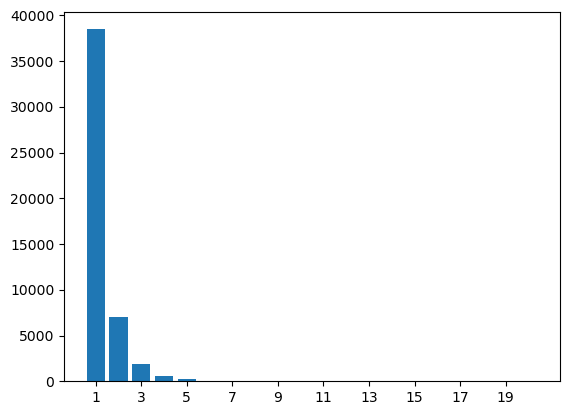

62364 observations reduced to 48273 clusters


In [26]:
h,x=np.histogram(a=nMems,bins=np.arange(0.5,20.51,1.))
xc=0.5*(x[0:-1] + x[1:])
plt.bar(x=xc,height=h)
plt.xticks(ticks=xc[::2],labels=xc[::2].astype(int))
plt.show()
print('{:d} observations reduced to {:d} clusters'.format(len(gdfE2),max(gdfE2['clusterIndex'])))